In [14]:
!pip install tensorflow==2.11.0
import tensorflow as tf
print(tf.__version__)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protob

In [16]:
!pip install keras_cv

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [18]:
!pip install keras-tuner -q

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras_cv, keras_tuner



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [21]:
batch_size = 64
image_size = (224, 224)
num_classes = 555
ds_size = 38562

label_order = [str(i) for i in range(555)]

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/birds23wi/birds/train/",
    labels="inferred",
    label_mode="int",
    class_names=label_order,
    seed=1337,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.05,
    subset="both"
)

Found 38562 files belonging to 555 classes.
Using 36634 files for training.
Using 1928 files for validation.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.set_title(labels[i].numpy())
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Train Specific Model

def make_specific_model():
    input_shape=(224,224, 3)
    num_classes=555
    mag = 0.7
    lr = 0.06
    dropout = 0.125
    
    resnet = keras.applications.ResNet50(weights="imagenet", pooling="avg", include_top=False)
    resnet.trainable=True
    
    inputs = keras.Input(shape=input_shape) 
    inputs = keras_cv.layers.RandAugment((0, 255), magnitude=mag)(inputs)
    x = resnet(inputs)
    
    x = layers.Dropout(rate=dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    )
    return model

model = make_specific_model()
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("/kaggle/working/callbacks.keras"),
]
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

In [ ]:
model.summary()
model.save("kaggle/working/models/adjusted_classes")

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/birds23wi/birds/test/",
    labels=None,
    shuffle=False,
    batch_size=batch_size,
    image_size=image_size
)

In [ ]:
import os
files = []
for dirname, _, filenames in os.walk('/kaggle/input/birds23wi/birds/test/0'):
    for filename in sorted(filenames):
        files.append("test/" + filename)

In [ ]:
paths = pd.DataFrame(files, columns=["path"])

In [ ]:
print(paths)

In [ ]:
predictions = model.predict(test_ds)


In [ ]:
classified = np.argmax(predictions, axis=1)

In [ ]:
df = pd.DataFrame(classified, columns= ["class"])

In [ ]:
print(df)

In [ ]:
preds = pd.concat((paths, df), axis=1)

In [ ]:
print(preds)

In [ ]:
preds.to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
model.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds
)

In [ ]:
def make_model(hp):
    input_shape=(224,224, 3)
    num_classes=555
    
    resnet = keras.applications.ResNet50(weights="imagenet", pooling="avg", include_top=False)
    resnet.trainable=True
    
    inputs = keras.Input(shape=input_shape) 
    augment_magnitude = hp.Float("magnitude", min_value=0.1, max_value=0.9, step=0.2)
    inputs = keras_cv.layers.RandAugment((0, 255), magnitude=augment_magnitude)(inputs)
    x = resnet(inputs)
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    dropout = hp.Float("dropout", min_value=0, max_value=0.5, step=0.125)
    
    x = layers.Dropout(rate=dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    )
    return model


model = make_model(keras_tuner.HyperParameters())

In [ ]:
# Train model
epochs = 7

# callbacks = [
#     keras.callbacks.ModelCheckpoint("/kaggle/working/callbacks.keras"),
# ]
# Maybe add validation
# model.fit(
#     train_ds,
#     epochs=epochs,
#     validation_data=val_ds
# )

tuner = keras_tuner.RandomSearch(
    hypermodel=make_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/kaggle/working",
    project_name="search",
)

tuner.search(train_ds, epochs=epochs, validation_data=val_ds)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [7]:
names = []
with open("/kaggle/input/birds23wi/birds/names.txt", 'r') as f:
    for line in f:
        names.append(line.strip())

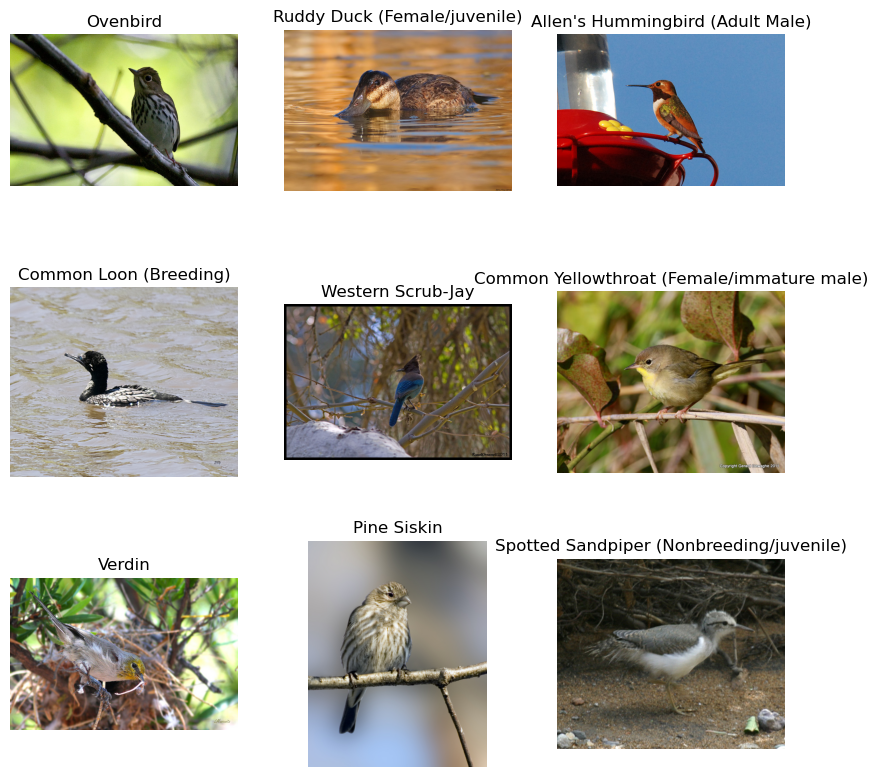

In [13]:
preds = pd.read_csv("/kaggle/input/submission/submission.csv")
plt.figure(figsize=(10, 10))
for i in range(9):
    uri = preds.at[i, 'path'][4:]
    pred_index = preds.at[i, 'class']
    img = np.asarray(Image.open("/kaggle/input/birds23wi/birds/test/0" + uri))
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(names[pred_index])
    plt.imshow(img)
    plt.axis("off")

In [22]:
val_augmented = val_ds.map(
    lambda x, y: (keras_cv.layers.RandAugment((0, 255), magnitude=0.7)(x, training=True), y))

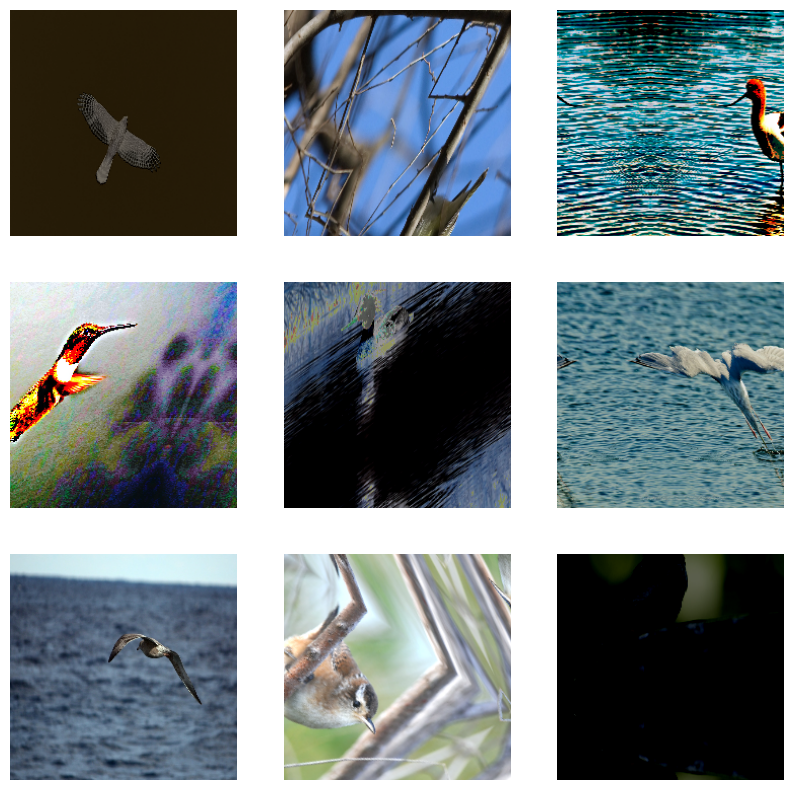

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in val_augmented.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")